In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('/Users/john-zaatri/Desktop/semester 7/פרויקט מסכם/tabular data/processed_data.csv')

print(df.head())

        Ocular Treatment ID    File   Age Gender    Eye Dominant Eye  \
0  267292-Right-Treatment-1  267292  51.0      M  Right           OD   
1   267292-Left-Treatment-1  267292  51.0      M   Left           OD   
2  271122-Right-Treatment-1  271122  31.0      M  Right           OD   
3   271122-Left-Treatment-1  271122  31.0      M   Left           OD   
4  274004-Right-Treatment-1  274004  44.0      F  Right           OS   

   Pachymetry  PRE-OP Average K  Pre-op K  Axis min  UCVA  ...  Alchohol  \
0       559.0             43.80                10.0  0.30  ...      -2.0   
1       573.0             44.07               160.0  0.30  ...      -2.0   
2       557.0             45.59                 3.0  0.35  ...      -2.0   
3       556.0             45.44               178.0  0.35  ...      -2.0   
4       513.0             46.51               177.0  0.01  ...      -2.0   

   PTK mmm  MZ sec  Therapeutic Cont L  Rotation Angle Degrees  \
0     -2.0    -2.0                  No      

In [3]:
# Drop relevant columns
df.drop(columns=['Op.Time'], inplace=True)
df.drop(columns=['Last_Target Sph'], inplace=True)

In [4]:
print(df.dtypes)

Ocular Treatment ID        object
File                        int64
Age                       float64
Gender                     object
Eye                        object
Dominant Eye               object
Pachymetry                float64
PRE-OP Average K          float64
Pre-op K  Axis min        float64
UCVA                      float64
Subjective SEQ            float64
Subjective Cyl Axis       float64
Subjective BCVA           float64
Treatment SEQ             float64
Treatment Param Axis      float64
Opt Zo                    float64
Max Abl Depth             float64
Treatment Type             object
Humidity                  float64
Temp                      float64
Micro                      object
Ring                      float64
Stop                      float64
Head                       object
Alchohol                  float64
PTK mmm                   float64
MZ sec                    float64
Therapeutic Cont L         object
Rotation Angle Degrees    float64
Last_UCVA     

In [5]:
# Preprocess the data (convert non numeric data types to label encoder)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != "Ocular Treatment ID": ############################### check
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

In [6]:
# for col, encoder in label_encoders.items():
#     print(f"Column: {col}")
#     print("Encoded Values:")
#     for original_value, encoded_value in zip(encoder.classes_, encoder.transform(encoder.classes_)):
#         print(f"{original_value}: {encoded_value}")
#     print()


In [7]:
print(len(df))

115551


In [8]:
# List of encoded treatment types
treatment_types = [0, 1, 2]  # Femto Lasik, Lasik, PRK

# Initialize dictionaries to hold train, validation, and test data (for each treatment type)
train_data = {}
val_data = {}
test_data = {}

# Loop over each treatment type
for treatment_type in treatment_types:
    # Filter data for the current treatment type
    treatment_data = df[df['Treatment Type'] == treatment_type]
    
    # Split the data into train and test sets (80% train, 20% test)
    train_data[treatment_type], test_data[treatment_type] = train_test_split(treatment_data, test_size=0.2, random_state=42)
    
    # Further split the train data into train and validation sets (80% train, 20% validation)
    train_data[treatment_type], val_data[treatment_type] = train_test_split(train_data[treatment_type], test_size=0.2, random_state=42)

# Concatenate data from all treatment types
train_data_all = pd.concat(train_data.values())
val_data_all = pd.concat(val_data.values())
test_data_all = pd.concat(test_data.values())

In [9]:
# Drop the target columns and also Ocular Treatment ID, File columns
X_train = train_data_all.drop(columns=['Last_UCVA', 'Ocular Treatment ID', 'File'])
X_val = val_data_all.drop(columns=['Last_UCVA', 'Ocular Treatment ID', 'File'])
X_test = test_data_all.drop(columns=['Last_UCVA', 'Ocular Treatment ID', 'File'])

# Extract the target variable
y_train = train_data_all['Last_UCVA']
y_val = val_data_all['Last_UCVA']
y_test = test_data_all['Last_UCVA']

In [10]:
# Scaler can help us scale the data before feeding it to the model, this way we reduce the bias to help the model learn better from the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Building tensors for the model
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

In [19]:
# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.0001

In [20]:
class Net(nn.Module):
    # Start by testing a small network built with layers of 100, 100, 30
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 30)
        self.fc4 = nn.Linear(30, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
# model, loss function, and optimizer
model = Net()
criterion = nn.MSELoss() # MSE (Mean Squared Error)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam is used as an optimizer

In [21]:
# Data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

In [22]:
# Train the model

# Save losses for further analysis
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/10], Training Loss: 0.0872, Validation Loss: 0.1255
Epoch [2/10], Training Loss: 0.0505, Validation Loss: 0.0779
Epoch [3/10], Training Loss: 0.0476, Validation Loss: 0.0490
Epoch [4/10], Training Loss: 0.0461, Validation Loss: 0.0459
Epoch [5/10], Training Loss: 0.0456, Validation Loss: 0.0453
Epoch [6/10], Training Loss: 0.0447, Validation Loss: 0.0474
Epoch [7/10], Training Loss: 0.0441, Validation Loss: 0.0467
Epoch [8/10], Training Loss: 0.0435, Validation Loss: 0.0421
Epoch [9/10], Training Loss: 0.0430, Validation Loss: 0.0409
Epoch [10/10], Training Loss: 0.0426, Validation Loss: 0.0460


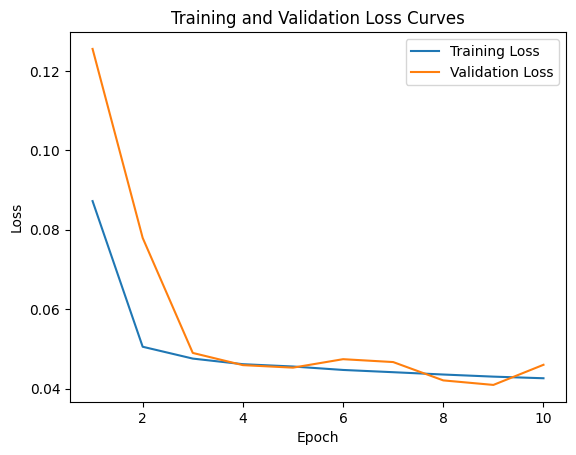

In [23]:
# Plotting the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # Plot Training and Validation Accuracy Curves
# plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
# plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy Curves')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [24]:
# Calculate Mean Absolute Error (MAE)
with torch.no_grad():
    total_mae = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        total_mae += torch.mean(torch.abs(outputs - targets)).item()
    mae = total_mae / len(test_loader)

print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Calculate Mean Squared Error (MSE)
with torch.no_grad():
    total_mse = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        total_mse += torch.mean((outputs - targets) ** 2).item()
    mse = total_mse / len(test_loader)

print(f'Mean Squared Error (MSE): {mse:.4f}')


Mean Absolute Error (MAE): 0.1314
Mean Squared Error (MSE): 0.0390


In [18]:
# # Set option to display all columns
# pd.set_option('display.max_columns', None)

# # Set option to display all rows
# pd.set_option('display.max_rows', None)